# Gradient Boosting
## Import Libraries

In [22]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
from Utils import plot_correlation_heatmap, plot_mi_heatmap, plotMetricsGraphComparison
from FeatureSelectionUtils import compute_permutation_importance, plot_feature_importance, export_final_selected_features_to_csv

## Import Train and Test Datasets

In [24]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


In [25]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Version": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Version": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In this notebook, we will explore Gradient Boosting. It builds a strong predictive model by combining an ensemble of weak learners, typically decision trees. It works by iteratively fitting new models to the residual errors of the previous models, with each subsequent model focusing on the areas where the previous ones performed poorly.

The model will first be trained with all available features on the default setting, then apply feature selection method to select the optimal set of features, and perform hyperparameter tuning. The performance of the model in each stage will be observed and compared.

For Boosting models, there are 2 common ways for feature selection:
1. In-built Feature Importance Score: Boosting algorithms compute feature importance scores during the training process. Feature importance scores are typically based on metrics such as the total reduction in impurity (e.g., Gini impurity or entropy) achieved by splitting on a particular feature across all decision trees in the ensemble. These scores reflect the contribution of each feature to the overall performance of the model.
2. Permutation Importance: It assesses the importance of each feature by measuring how much the model's performance deteriorates when the values of that feature are randomly shuffled (permuted). The drop in performance after permutation reflects the importance of the feature: a larger drop indicates a more important feature, while a smaller drop suggests a less important feature. Permutation importance provides a more robust assessment of feature importance compared to feature importance scores, as it directly measures the impact of each feature on the model's performance.

Compared to Recursive Feature Elimination, in-built feature selection methods like feature importance scores and permutation importance are generally preferred in the context of boosting algorithms, as they offer a more comprehensive and efficient approach to feature selection based on the model's behavior and performance.

In [132]:
# Set up a dataframe to store the results from different versions
train_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Classification Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Build the Baseline Model before Feature Engineering

In [27]:
# Read columns used to build models
columns = pd.read_csv('Data/basic_model_columns.csv')['Columns'].to_list()

In [28]:
X_train_basic = pd.read_csv('Data/X_train_undersampled_data.csv')[columns]
X_test_basic = pd.read_csv('Data/X_test.csv')[columns]

print("Train Set :", Y_train.shape, X_train_basic.shape)
print("Test Set  :", Y_test.shape, X_test_basic.shape)

Train Set : (20392, 1) (20392, 39)
Test Set  : (8176, 1) (8176, 39)


In [133]:
gb_basic = GradientBoostingClassifier(random_state=47).fit(X_train_basic, Y_train.values.ravel())

In [134]:
# Predict the output based on our training and testing dataset
Y_train_pred_basic = gb_basic.predict(X_train_basic)
Y_test_pred_basic = gb_basic.predict(X_test_basic)

In [135]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_basic, Y_test, Y_test_pred_basic, "Baseline before Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8393978030600235
Precision 	: 0.8492984758251741
Recall 		: 0.8252255786582974
F1 Score 	: 0.8370889916927823

**Test Set Metrics**
Accuracy 	: 0.8337818003913894
Precision 	: 0.6415425065731815
Recall 		: 0.4351961950059453
F1 Score 	: 0.5185972369819342


## Build the Baseline Model after Feature Engineering

In [136]:
gb = GradientBoostingClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [137]:
# Predict the output based on our training and testing dataset
Y_train_pred = gb.predict(X_train)
Y_test_pred = gb.predict(X_test)

In [138]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline after Feature Engineering", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8478815221655551
Precision 	: 0.8548419367747099
Recall 		: 0.8380737544134955
F1 Score 	: 0.8463748019017432

**Test Set Metrics**
Accuracy 	: 0.8257093933463796
Precision 	: 0.5900490539593553
Recall 		: 0.5005945303210464
F1 Score 	: 0.5416532647153426


From the results, we can see a great improvement in model performance after feature engineering.

## Eliminate the Features with permutation_importance=0

This step aims to remove features that do not contribute to the model's ability to capture meaningful patterns in the data.

In [35]:
feature_importances, feature_names = compute_permutation_importance(gb, X_train, Y_train)

In [36]:
# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

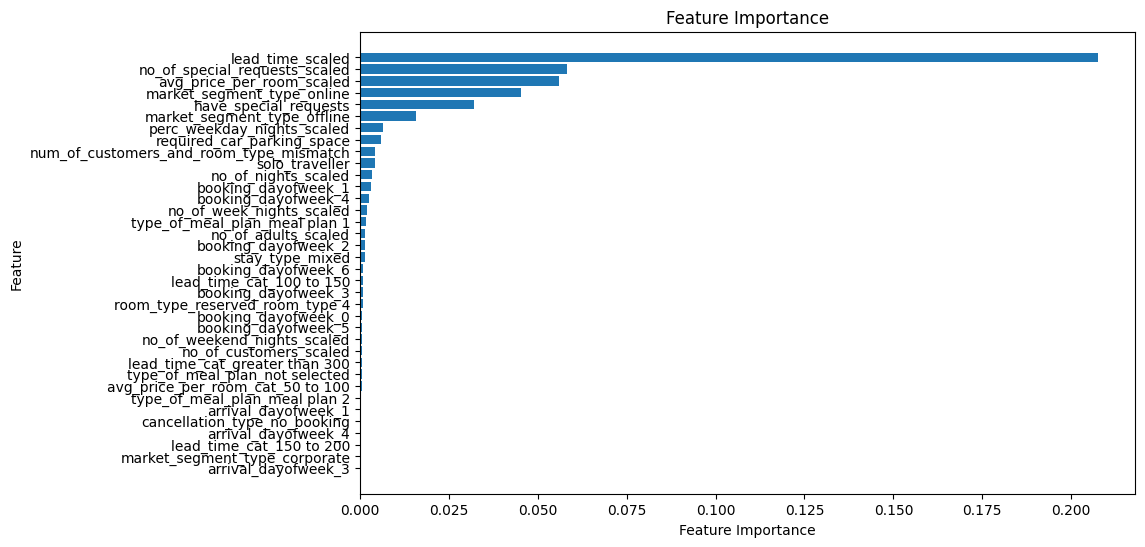

In [37]:
# Visualize permutation_importance
plot_feature_importance(feature_importances, feature_names)

In [38]:
selected_columns = feature_names

## Fit the Model again with the selected set of features

In [39]:
gb_selected = GradientBoostingClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [40]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = gb_selected.predict(X_train[selected_columns])
Y_test_pred_selected = gb_selected.predict(X_test[selected_columns])

In [328]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8471949784229109
Precision 	: 0.853505092869982
Recall 		: 0.8382699097685367
F1 Score 	: 0.845818901533894

**Test Set Metrics**
Accuracy 	: 0.8261986301369864
Precision 	: 0.5914505956552207
Recall 		: 0.5017835909631391
F1 Score 	: 0.5429398520424574


## Eliminate Features with low in-built feature importance

This step involves leveraging the in-built feature importance score to gain insights into how each feature interacts with our model. To determine the optimal number of features to retain, we employ an iterative approach. Beginning with the most important feature, we incrementally add features to train the model. Subsequently, we plot the evaluation metrics across different numbers of features. The f1 score is selected as the primary metric for evaluation during this process.

In [ ]:
# Initialize variables to store the best F1 score and corresponding set of features
best_f1_score = 0
best_num_features = 0
best_feature_set_1 = []

# Initialize lists to store the F1 scores and the number of features
f1_scores = []
num_features_selected = []

# Sort feature importances in descending order
feature_importances = gb_selected.feature_importances_
sorted_indices = (-feature_importances).argsort()

# Train the gradient boosting classifier on subsets of features
for i in range(1, len(selected_columns) + 1):
    # Select top 'i' features based on sorted indices
    top_features = selected_columns[sorted_indices[:i]]
    gb = GradientBoostingClassifier(random_state=47)
    gb.fit(X_train[top_features], Y_train.values.ravel())
    
    # Make predictions on the test dataset
    Y_train_pred = gb.predict(X_train[top_features])
    
    # Calculate the F1 score
    f1 = f1_score(Y_train, Y_train_pred)
    
    # Update the best F1 score and corresponding set of features if necessary
    if f1 > best_f1_score:
        best_f1_score = f1
        best_num_features = i
        best_feature_set_1 = top_features
    
    # Append the F1 score and the number of features selected
    f1_scores.append(f1)
    num_features_selected.append(i)

Best set of features: Index(['lead_time_scaled', 'market_segment_type_online',
       'avg_price_per_room_scaled', 'have_special_requests',
       'no_of_special_requests_scaled', 'market_segment_type_offline',
       'num_of_customers_and_room_type_mismatch', 'required_car_parking_space',
       'perc_weekday_nights_scaled', 'no_of_week_nights_scaled',
       'no_of_nights_scaled', 'booking_dayofweek_1',
       'no_of_weekend_nights_scaled', 'solo_traveller', 'stay_type_mixed',
       'booking_dayofweek_2', 'no_of_customers_scaled', 'no_of_adults_scaled',
       'booking_dayofweek_4', 'booking_dayofweek_5',
       'type_of_meal_plan_meal plan 2', 'avg_price_per_room_cat_50 to 100',
       'booking_dayofweek_6', 'type_of_meal_plan_not selected',
       'room_type_reserved_room_type 4', 'arrival_dayofweek_1',
       'booking_dayofweek_0', 'lead_time_cat_greater than 300',
       'booking_dayofweek_3', 'cancellation_type_no_booking'],
      dtype='object')
Number of features: 30
Best F1 

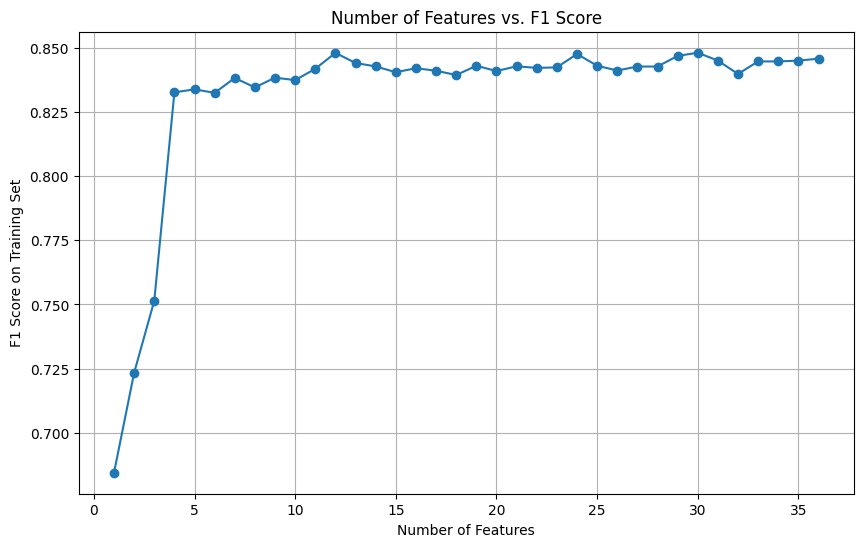

In [51]:
# Plot the number of features vs. F1 score
plt.figure(figsize=(10, 6))
plt.plot(num_features_selected, f1_scores, marker='o', linestyle='-')
plt.title('Number of Features vs. F1 Score')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score on Training Set')
plt.grid(True)

# Print the best set of features and the corresponding number of features
print("Best set of features:", best_feature_set_1)
print("Number of features:", best_num_features)
print("Best F1 score:", best_f1_score)

plt.show()

Rather than retaining the exact number of features that yield the optimal F1 score, we opt to keep the top 12 features. While these features still demonstrate competitive performance, selecting a smaller number helps reduce the dimensionality of the feature space, enhancing computational efficiency and potentially mitigating overfitting concerns.

In [53]:
# Get feature importance score
feature_importances = gb_selected.feature_importances_
# Get feature names
feature_names = selected_columns

# Get indices that would sort feature importances
sorted_indices = np.argsort(-feature_importances)

# Retain the top 12 features
feature_names = feature_names[sorted_indices[:12]]
feature_importances = feature_importances[sorted_indices[:12]]

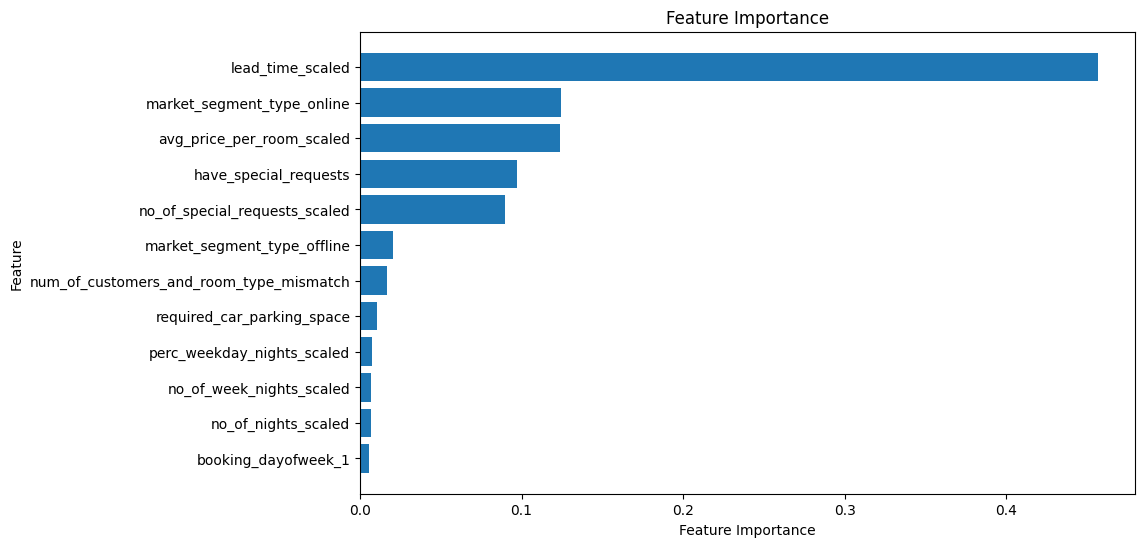

In [55]:
# Visualize permutation_importance
plot_feature_importance(feature_importances[::-1], feature_names[::-1])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

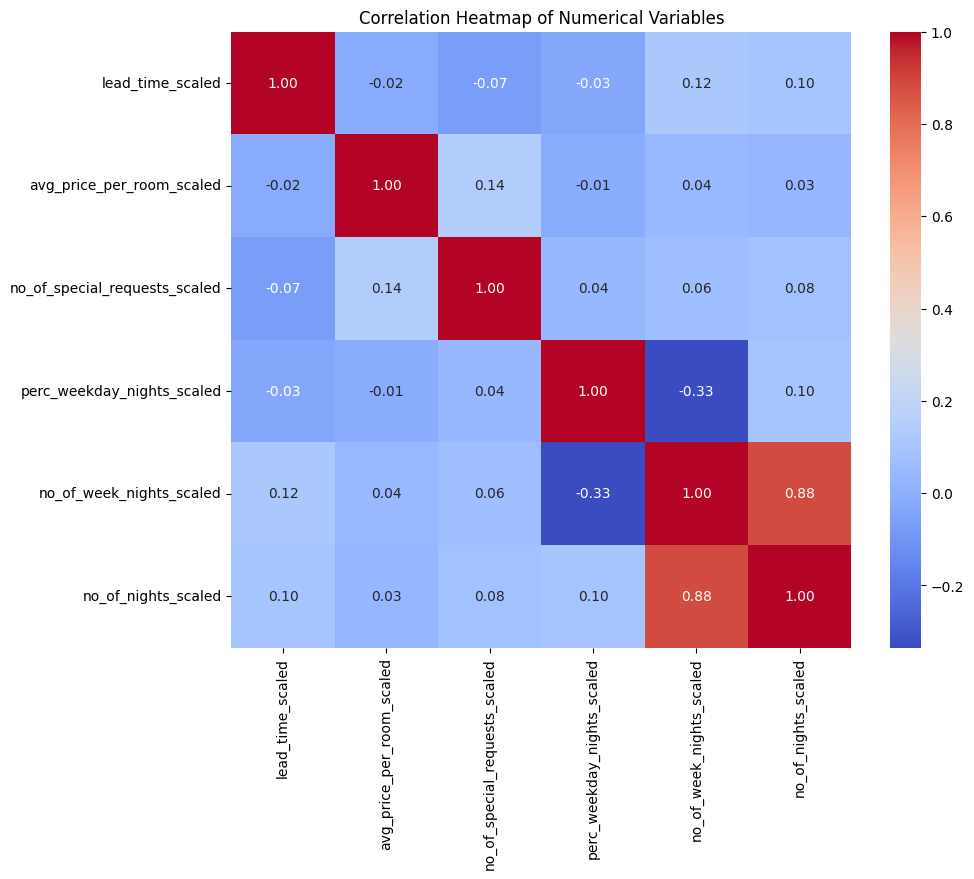

In [57]:
# correlation between numerical features
num_cols = [x for x in feature_names if '_scaled' in x]
plot_correlation_heatmap(X_train[num_cols])

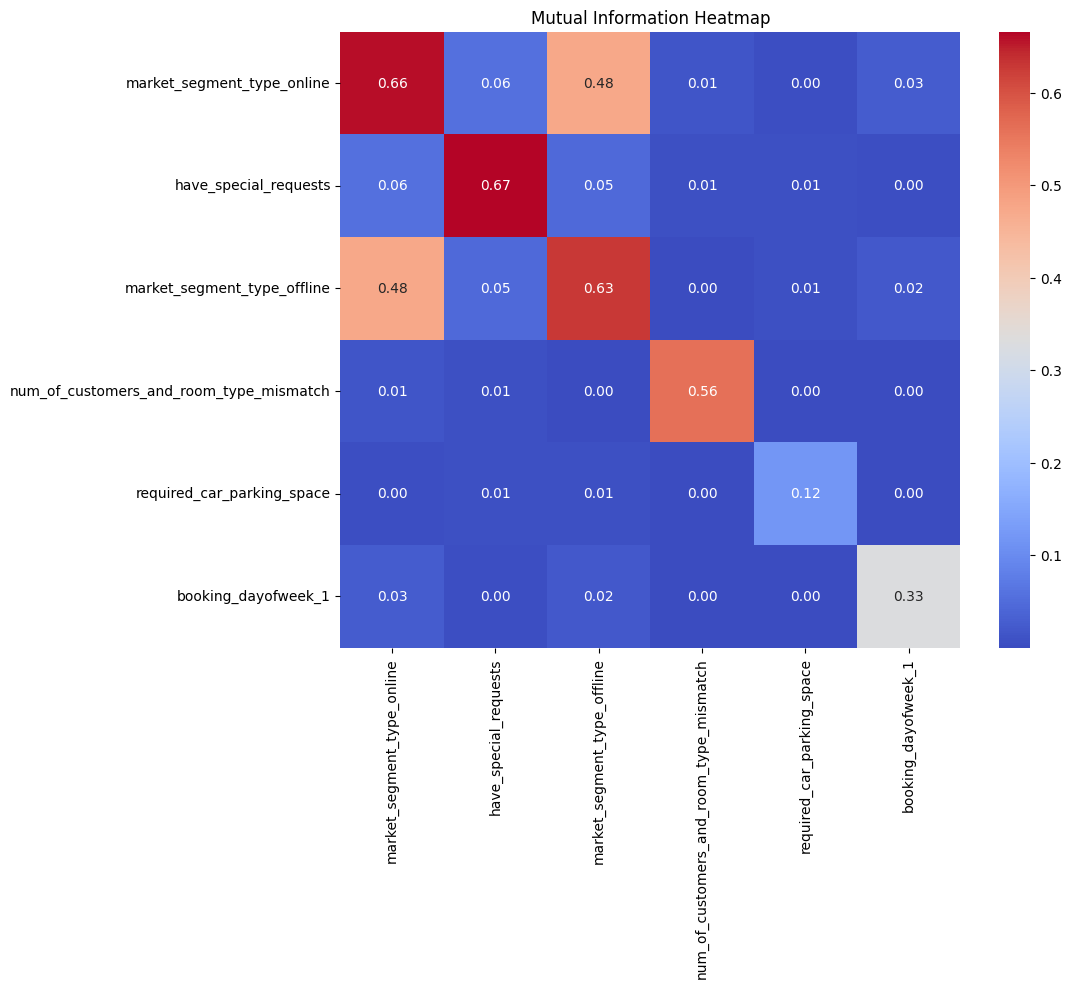

In [64]:
# mutual information between categorical features
cat_cols = [x for x in feature_names if x not in num_cols]
plot_mi_heatmap(X_train[cat_cols])

Based on the observations, 'no_of_nights_scaled' and 'market_segment_type_offline' have higher correlation with some other features and will be removed.

In [65]:
to_remove = ['no_of_nights_scaled', 'market_segment_type_offline']
final_columns = [x for x in feature_names if x not in to_remove]

## Fit the model with the final set of features

In [139]:
gb_selected_final = GradientBoostingClassifier(random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [140]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected_final = gb_selected_final.predict(X_train[final_columns])
Y_test_pred_selected_final = gb_selected_final.predict(X_test[final_columns])

In [141]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected_final, Y_test, Y_test_pred_selected_final, "Final Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8367987446057278
Precision 	: 0.8453338696701529
Recall 		: 0.8244409572381326
F1 Score 	: 0.8347567030784508

**Test Set Metrics**
Accuracy 	: 0.8259540117416829
Precision 	: 0.5888812628689087
Recall 		: 0.5101070154577884
F1 Score 	: 0.5466709143039185


## Hyperparameter Tuning

For GradientBoostingClassifier, there are several hyperparameters to tune:
1. n_estimators (default=100): The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
2. learning_rate (default=0.1): Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
3. max_depth (default=3): Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
4. min_samples_split (default=2): The minimum number of samples required to split an internal node.
5. min_samples_leaf (default=1): The minimum number of samples required to be at a leaf node.
6. subsample (default=1.0): The fraction of samples to be used for fitting the individual base learners.
7. max_features (default=None): The number of features to consider when looking for the best split.

### Tuning n_estimators

In [69]:
parameters_n_estimators = {
    'n_estimators': range(50, 300, 50),
    }
model = GradientBoostingClassifier(random_state=47)
grid_search_n_estimators = GridSearchCV(model, param_grid=parameters_n_estimators, cv=5, scoring='f1', verbose=1)
grid_search_n_estimators.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=47),
             param_grid={'n_estimators': range(50, 300, 50)}, scoring='f1',
             verbose=1)

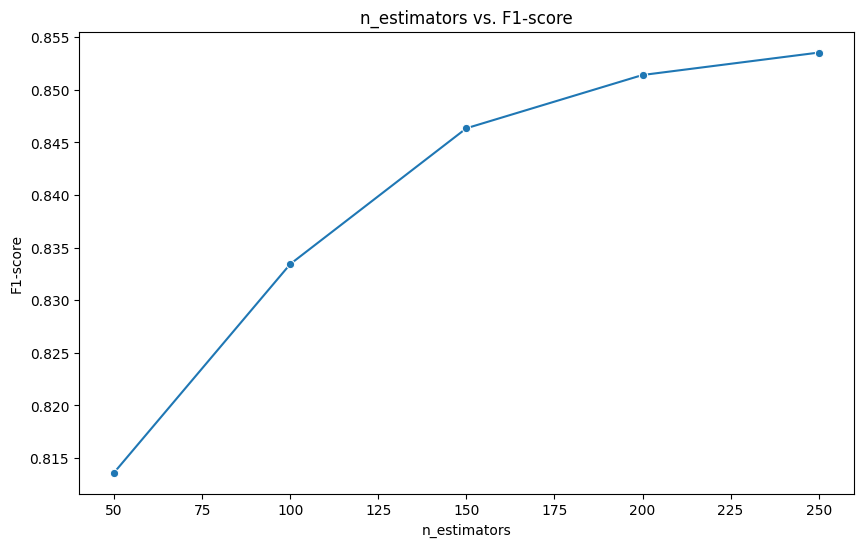

In [70]:
plt.figure(figsize=(10, 6))

# Plotting n_estimators vs. f1
sns.lineplot(x=list(range(50, 300, 50)), y=grid_search_n_estimators.cv_results_['mean_test_score'], marker='o')
plt.title('n_estimators vs. F1-score')
plt.xlabel('n_estimators')
plt.ylabel('F1-score')
plt.show()

The improvement becomes more apparent as the number of estimators increases from 50 to 150. Beyond this point, however, the improvement becomes more subtle. Therefore, we decide to proceed with n_estimators=150 for the subsequent tuning steps.

### Tune learning_rate

In [74]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
model = GradientBoostingClassifier(n_estimators=150, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=1)
grid_search_learning_rate.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2]}, scoring='f1',
             verbose=1)

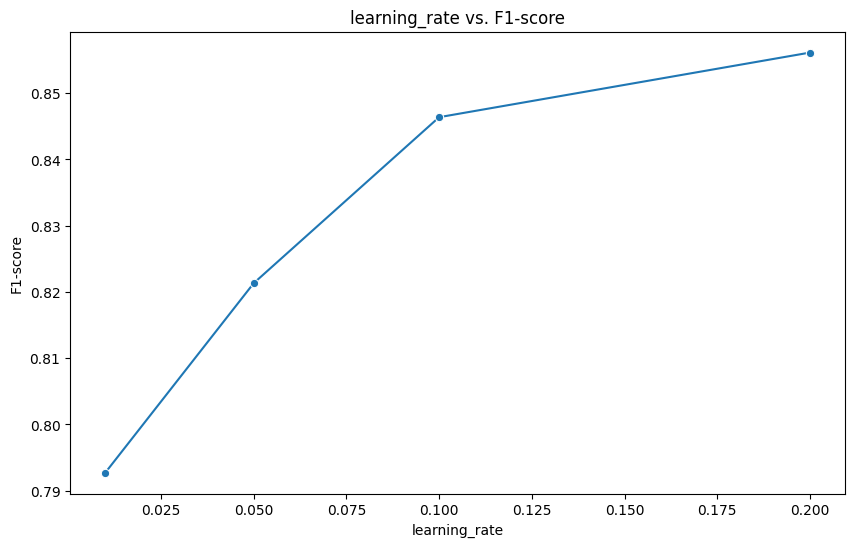

In [75]:
plt.figure(figsize=(10, 6))

# Plotting learning rate vs. f1
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. F1-score')
plt.xlabel('learning_rate')
plt.ylabel('F1-score')
plt.show()

The optimal solution for learning_rate remains at 0.1, as further increases result in diminishing improvements.

### Tune max_depth, min_samples_split, and min_samples_leaf

In [76]:
parameters_tree = {
    'max_depth':range(2,5,1), 
    'min_samples_split':[2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10]
    }
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, random_state=47)
grid_search_tree = GridSearchCV(model, param_grid=parameters_tree, cv=5, scoring='f1', verbose=1)
grid_search_tree.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 5),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=1)

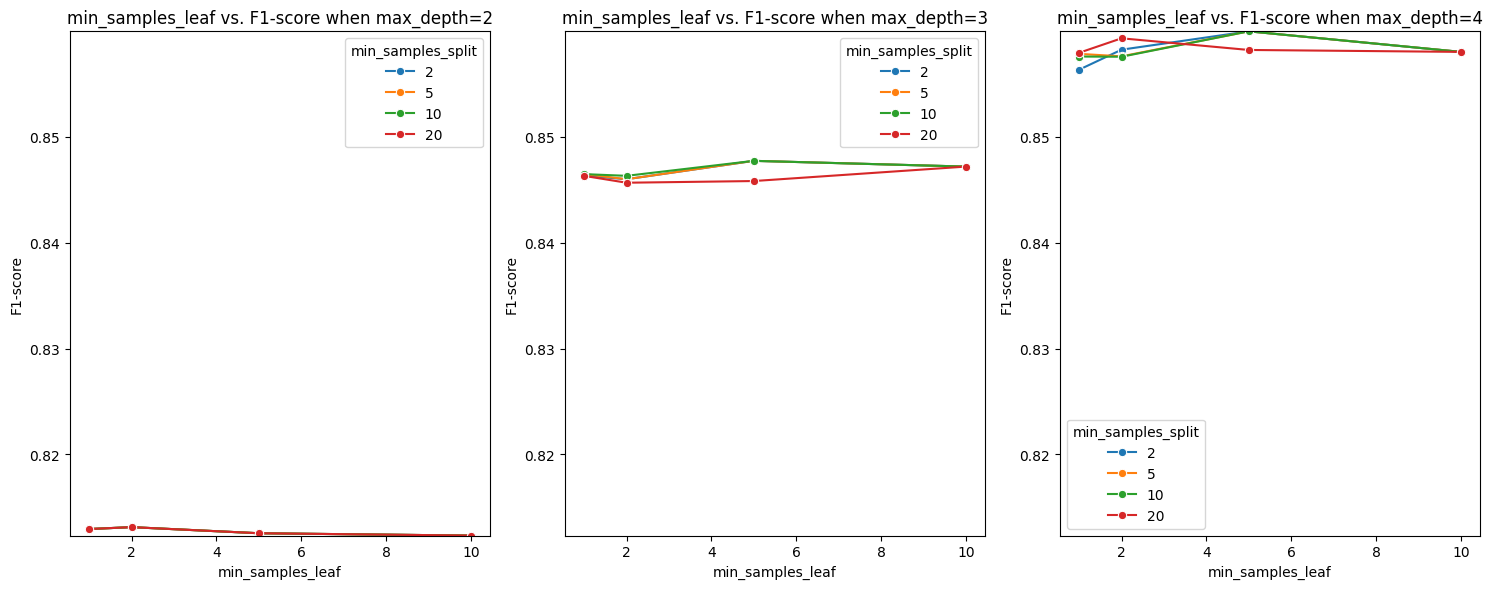

In [77]:
plt.figure(figsize=(15, 6))

# Plotting max_depth, min_samples_leaf, min_samples_split vs. f1
for i in range(3):
    plt.subplot(1, 3, i+1)
    for j in range(4):
        sns.lineplot(x=[1, 2, 5, 10], y=grid_search_tree.cv_results_['mean_test_score'][list(range(j+i*16, 16+i*16, 4))], marker='o', label=f'{[2, 5, 10, 20][j]}')
    plt.title(f'min_samples_leaf vs. F1-score when max_depth={[2,3,4][i]}')
    plt.ylim(min(grid_search_tree.cv_results_['mean_test_score']), max(grid_search_tree.cv_results_['mean_test_score']))
    plt.xlabel('min_samples_leaf')
    plt.ylabel('F1-score')
    plt.legend(title="min_samples_split") 
    plt.tight_layout()
plt.show()

The performance differences introduced by adjusting min_samples_leaf and min_samples_split appear subtle, so we opt to retain their default settings: min_samples_leaf=1 and min_samples_split=2. Our focus will then shift to tuning max_depth alone, as we anticipate that this will reveal clearer patterns in the model's performance.

### Tune max_depth alone

In [78]:
parameters_max_depth = {
    'max_depth':range(2,8,1)
    }
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=1)
grid_search_max_depth.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 8)}, scoring='f1', verbose=1)

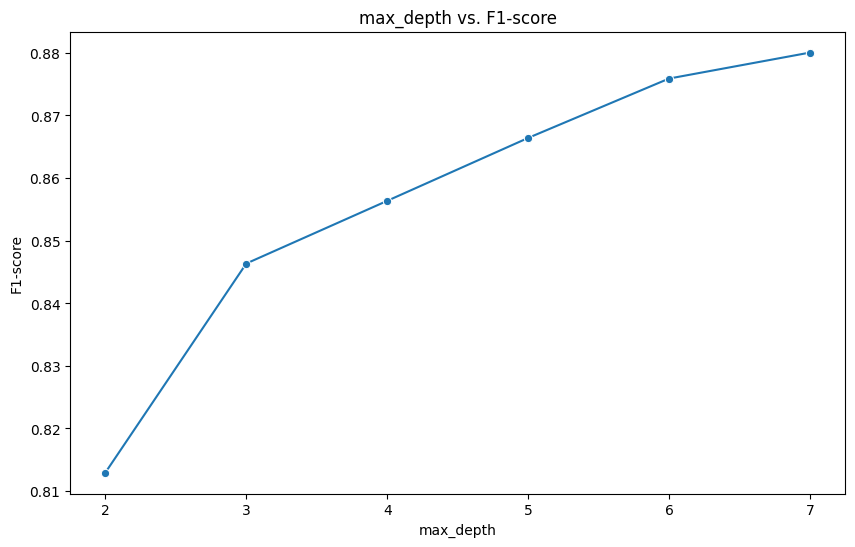

In [79]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. f1
sns.lineplot(x=range(2,8,1), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

The results indicate that the model's performance improves as max_depth increases. However, this improvement may be attributed to the model overfitting to the training data. To mitigate this risk and prevent overfitting, we choose a smaller max_depth and retain the default setting: max_depth=6.

### Tune subsample and max_features

In [90]:
parameters_subsample = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_features': [0.6, 0.8, 1]
    }
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, max_depth=6, random_state=47)
grid_search_subsample = GridSearchCV(model, param_grid=parameters_subsample, cv=5, scoring='f1', verbose=1)
grid_search_subsample.fit(X_train[final_columns], Y_train.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=6, n_estimators=30,
                                                  random_state=47),
             param_grid={'max_features': [0.6, 0.8, 1],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='f1', verbose=1)

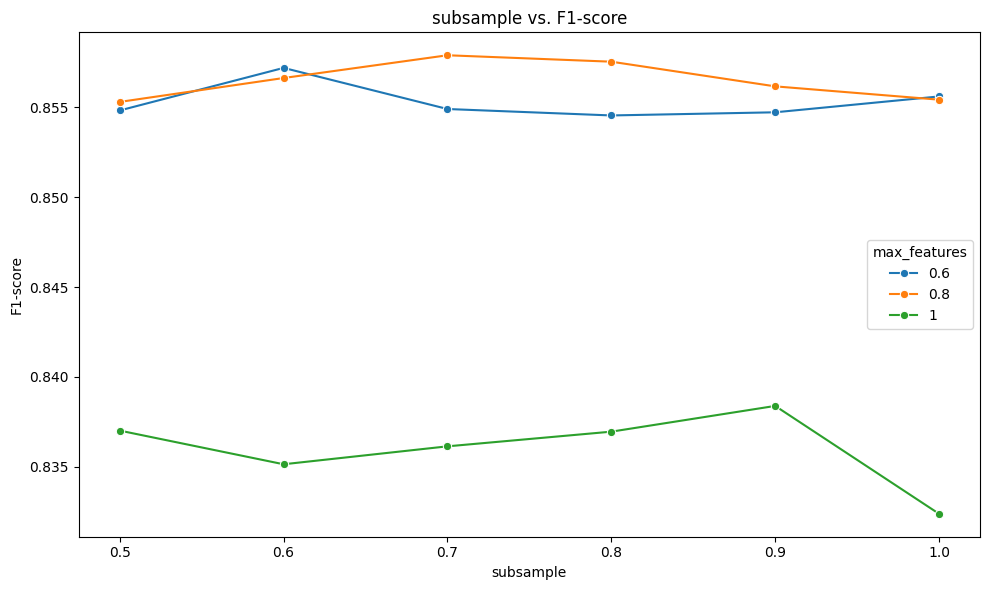

In [91]:
plt.figure(figsize=(10, 6))

# Plotting subsample, max_feature vs. f1
for i in range(3):
    sns.lineplot(x=[0.5, 0.6, 0.7, 0.8, 0.9, 1], y=grid_search_subsample.cv_results_['mean_test_score'][list(range(i*6, 6+i*6, 1))], marker='o', label=f"{['0.6', '0.8', '1'][i]}")
plt.title(f'subsample vs. F1-score')
plt.xlabel('subsample')
plt.ylabel('F1-score')
plt.legend(title="max_features") 
plt.tight_layout()
plt.show()

Choosing a smaller max_features value demonstrates optimal performance compared to using the default setting (max_features=1), and 0.8 exhibits slightly better performance. Therefore, we decide to keep the max_features value at 0.8. However, tuning subsample does not significantly affect performance; hence, we will retain the default setting (subsample=1).

## Fit the Model again the tuned hyperparameters

In [142]:
gb_tuned = GradientBoostingClassifier(n_estimators=150, max_depth=6, max_features=0.8, random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [143]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = gb_tuned.predict(X_train[final_columns])
Y_test_pred_tuned = gb_tuned.predict(X_test[final_columns])

In [144]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.9012357787367595
Precision 	: 0.9165987780040733
Recall 		: 0.8827971753628874
F1 Score 	: 0.8993804956035172

**Test Set Metrics**
Accuracy 	: 0.8279109589041096
Precision 	: 0.5950241879751209
Recall 		: 0.5118906064209274
F1 Score 	: 0.5503355704697986


## Evaluation

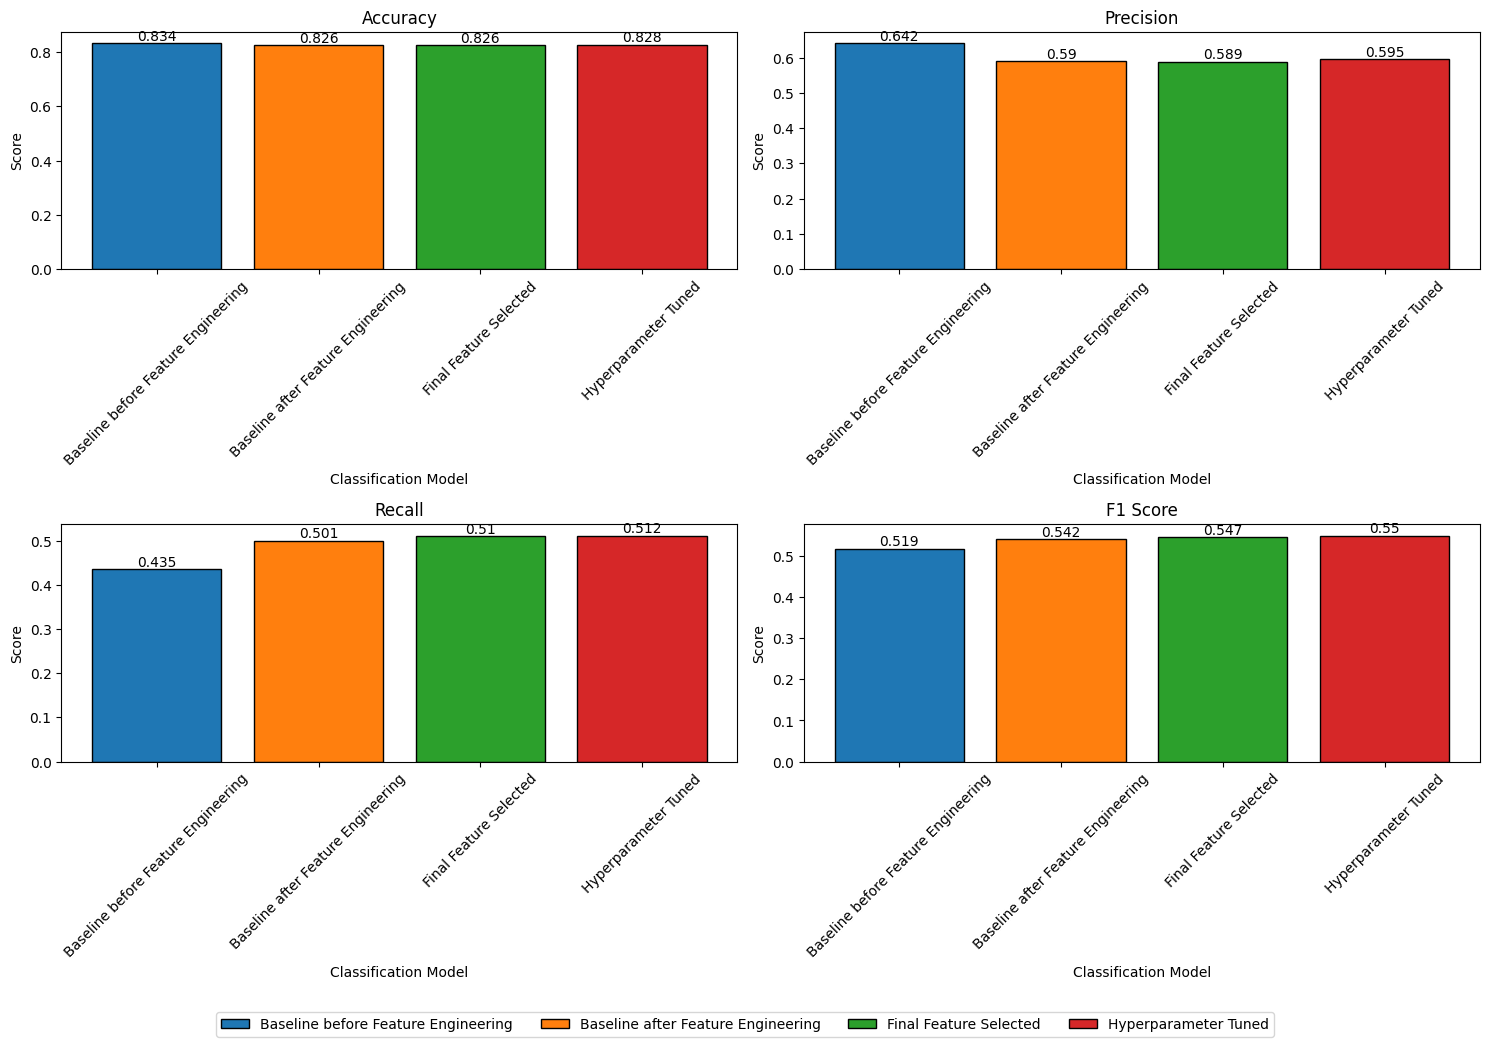

In [148]:
plotMetricsGraphComparison(test_metrics)

We observe a notable progression in model performance, particularly in terms of the f1 score. Despite exhibiting slightly lower accuracy than the baseline model prior to feature engineering, the hyperparameter-tuned model ultimately delivers optimal performance. This underscores the benefits introduced by feature engineering, which significantly enhances model performance by enabling us to capture more nuanced information through the creation of new features. Additionally, the feature selection step plays a crucial role in performance improvement by allowing us to retain only the most relevant features and mitigate overfitting.

Through hyperparameter tuning, we fine-tune the default settings by increasing n_estimators and max_depth, resulting in a more complex structure for the weaker learners. This adjustment enables the model to better capture the intricacies of the data. Furthermore, by reducing max_features to 0.8, we utilize fewer features to construct each weak learner. This strategic reduction enables us to enhance the representability of the less significant features, contributing to the overall performance enhancement of the model.

## Export

In [149]:
# export the features used for this model
export_final_selected_features_to_csv(final_columns, "Best Gradient Boosting")


Features exported successfully to FinalModels/Feature_Selection/Best Gradient Boosting


In [150]:
# export the best model to be compared later on
joblib.dump(gb_tuned, "FinalModels/BestGradientBoosting.pkl")

['FinalModels/BestGradientBoosting.pkl']